In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    median_absolute_error,
    explained_variance_score,
    mean_absolute_percentage_error
)

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)             
        out = self.linear(out[:, -1, :])  # pegar o último passo da sequência
        return out

In [4]:
# Parâmetros
window_size = 100  # tamanho do meu X
hidden_size = 64   # Camadas ocultas
n_steps=100        # horizonte de previsão
epochs = 1000       # number of epochs
lr = 0.001         # learning rate

In [5]:
df = pd.read_parquet("../dataset_temperature_c_interpolation.parquet")
df.head()

,time,Napier_Aerodrome,Wellington_Aerodrome,Enderby_Island,Mokohinau_Island,Cape_Campbell,Westport_Aerodrome,Mahia_NZMHX,Nelson_Aerodrome,Queenstown_Aerodrome,...,Port_Taharoa,Palmerston_N,Gisborne_Aerodrome,Nugget_Point,Dunedin_Aerodrome,Cape_Reinga,Secretary_Island,Kaitaia_Aerodrome,Takapau_Plains,split
0,01-Apr-1993 00:00,15.0,17.0,7.0,17.0,11.0,17.0,14.0,15.0,8.0,...,15.0,14.0,16.0,10.0,8.0,17.0,14.0,16.5,11.4,True
1,01-Apr-1993 01:00,14.0,17.0,7.0,17.0,11.0,16.0,14.0,15.0,8.0,...,14.0,15.0,15.0,10.0,8.0,16.0,14.0,16.5,11.4,True
2,01-Apr-1993 02:00,14.0,17.0,7.0,17.0,11.0,16.0,15.0,15.0,7.0,...,14.0,14.0,15.0,10.0,8.0,16.0,14.0,16.5,11.4,True
3,01-Apr-1993 03:00,13.0,17.0,7.0,17.0,11.0,16.0,15.0,14.0,6.0,...,15.0,14.0,14.0,10.0,8.0,16.0,14.0,16.5,11.4,True
4,01-Apr-1993 04:00,13.0,17.0,7.0,17.0,11.0,15.0,15.0,14.0,7.0,...,15.0,14.0,14.0,10.0,8.0,16.0,14.0,16.5,11.4,True


In [6]:
station = "Napier_Aerodrome"

In [7]:
train_data = df.query("split == True")[station].values[-1000:]
test_data  = df.query(" split == False ")[station].values[:500]
train_data.shape, test_data.shape

((1000,), (500,))

In [8]:
def create_dataset(series, window_size, horizon):
    """
    Gera X e y para previsão de múltiplos passos.

    Args:
        series (array-like): sequência de valores.
        window_size (int): tamanho da janela de entrada.
        horizon (int): número de passos à frente a prever.

    Returns:
        X: Tensor de forma (n_amostras, window_size)
        y: Tensor de forma (n_amostras, horizon)
    """
    X, y = [], []
    max_start = len(series) - window_size - horizon + 1
    for i in range(max_start):
        X.append(series[i : i + window_size])
        y.append(series[i + window_size : i + window_size + horizon])
        
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    return X, y

In [9]:
X_train, y_train = create_dataset(train_data, window_size, n_steps)
X_test, y_test = create_dataset(test_data, window_size, n_steps)

/tmp/ipykernel_3342765/35059170.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X = torch.tensor(X, dtype=torch.float32)


In [10]:
X_train = X_train.unsqueeze(-1)
X_test  = X_test.unsqueeze(-1)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [12]:
# Modelo
model = LSTMModel(input_size=window_size, 
                  hidden_size=hidden_size, 
                  num_layers=2, 
                  output_dim=n_steps)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [13]:
# Loop de treino
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

Epoch 0 - Loss: 337.5871
Epoch 10 - Loss: 328.9160
Epoch 20 - Loss: 306.0278
Epoch 30 - Loss: 274.8013
Epoch 40 - Loss: 245.1668
Epoch 50 - Loss: 219.6031
Epoch 60 - Loss: 197.4982
Epoch 70 - Loss: 177.9917
Epoch 80 - Loss: 160.6278
Epoch 90 - Loss: 145.0878
Epoch 100 - Loss: 131.1265
Epoch 110 - Loss: 118.5527
Epoch 120 - Loss: 107.2143
Epoch 130 - Loss: 96.9866
Epoch 140 - Loss: 87.7647
Epoch 150 - Loss: 79.4576
Epoch 160 - Loss: 71.9852
Epoch 170 - Loss: 65.2750
Epoch 180 - Loss: 59.2614
Epoch 190 - Loss: 53.8839
Epoch 200 - Loss: 49.0867
Epoch 210 - Loss: 44.8181
Epoch 220 - Loss: 41.0298
Epoch 230 - Loss: 37.6772
Epoch 240 - Loss: 34.7187
Epoch 250 - Loss: 32.1157
Epoch 260 - Loss: 29.8323
Epoch 270 - Loss: 27.8355
Epoch 280 - Loss: 26.0948
Epoch 290 - Loss: 24.5822
Epoch 300 - Loss: 23.2720
Epoch 310 - Loss: 22.1408
Epoch 320 - Loss: 21.1674
Epoch 330 - Loss: 20.3326
Epoch 340 - Loss: 19.6189
Epoch 350 - Loss: 19.0109
Epoch 360 - Loss: 18.4946
Epoch 370 - Loss: 18.0577
Epoch 380 

In [14]:
model.eval()
with torch.no_grad():
    preds = model(X_test)
    test_loss = criterion(preds, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 12.2094


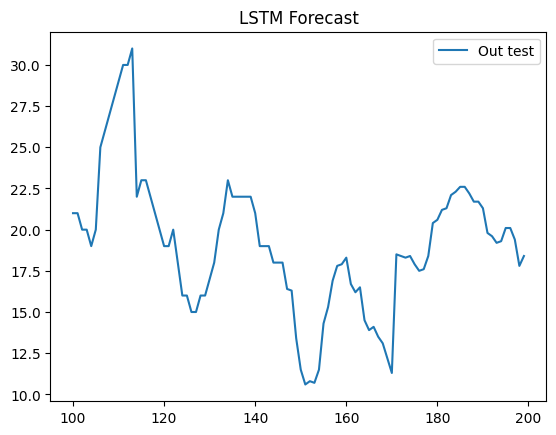

In [15]:
plt.plot(np.arange(100, 200), y_test.cpu().numpy()[0,:], label="Out test")

plt.legend()
plt.title("LSTM Forecast")
plt.show()

In [16]:
idx = 0

ytrues = []
ypreds = []

for i in range(4):
    
    y_true = y_test[idx,:].cpu().numpy().tolist()
    y_pred = preds[idx,:].cpu().numpy().tolist()
    
    ytrues.extend(y_true)
    ypreds.extend(y_pred)
    
    idx += 100

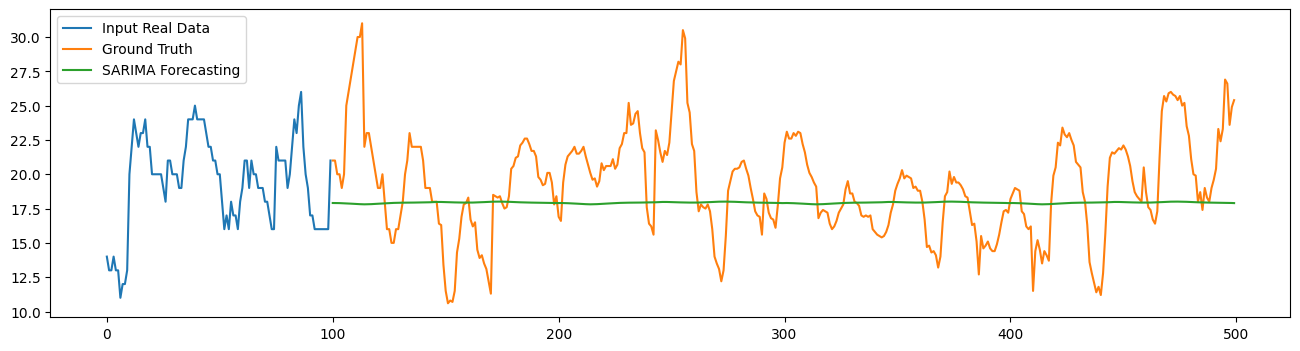

In [17]:
## create dataframe to save results
plt.figure(figsize=(16, 4))
plt.plot(np.arange(0, 100), test_data[0:100], label="Input Real Data ")
plt.plot(np.arange(100, len(ytrues)+100), ytrues, label="Ground Truth")
plt.plot(np.arange(100, len(ypreds)+100), ypreds, label="SARIMA Forecasting")
plt.legend()
plt.show()

In [18]:
from val import regression_metrics
metrics = regression_metrics(ytrues, ypreds)
metrics

{'DTW': 1195.0472469329834,
 'MAE': 3.011636962890625,
 'MSE': 15.095255840922759,
 'RMSE': 3.885261360696698,
 'MAPE': 15.584775138978916,
 'R2': -0.1264039393983425}